### [ 손글씨 숫자 인식 모델 구현 ]
- 데이터셋 : mnist_train.csv, mnist_test.csv
- 학습종류 : 지동학습 - 다중클래스분류
- 학습방법 : 인공신경망기반 

[1] 모듈로딩 및 데이터 준비<hr>

In [31]:
# [1-1] 모듈로딩
import torch                                            # 텐서 및 수치과학 함수들 관련 모듈
import torch.nn as nn                                   # 신경망 층 관련 모듈
import torch.nn.functional as F                         # 신경망 함수들(AF, LF, MF) 모듈
import torch.optim as optim                             # 신경망 최적화 모듈

from torch.utils.data import Dataset, DataLoader        # pytorch의 데이터 로딩
from torch.utils.data import Subset                     # pytorch의 데이터셋 관련 모듈
from sklearn.model_selection import train_test_split
import pandas as pd

import util_func as uf                                  # 학습 관련 함수들 


In [32]:
# [1-2] 데이터 준비
TRAIN_FILE = '../Data/mnist_train.csv'
TEST_FILE  = '../Data/mnist_test.csv'

## [1-3] 데이터 로딩
trainDF = pd.read_csv(TRAIN_FILE, header=None)
testDF  = pd.read_csv(TEST_FILE, header=None)


[2] 커스텀 데이터셋 준비 <hr>

In [33]:
## --------------------------------------------------------------------------------
## [2-1] 커스텀 데이터셋 클래스 정의
## --------------------------------------------------------------------------------
## 클래스이름 : ClfDataset
## 부모클래스 : Dataset
## 오버라이딩 : _ _init_ _(self)        : [필수] 피쳐, 타겟, [선택]행수, 컬럼수, 타겟 수...
##            _ _len_ _(self)          : len() 내장함수 실행 시 자동 호출, 샘플 수 반환
##            _ _getitem_ _(self, idx) : 인스턴스명[idx] 시 자동 호출,
##                                       idx에 해당하는 피쳐, 타겟을 텐서화 해서 반환
## --------------------------------------------------------------------------------
class ClfDataset(Dataset):

    ##- 피쳐와 타겟 저장 및 기타 속성 초기화 
    def __init__(self, dataDF):
        super().__init__()
        ## 피쳐, 타겟 초기화 필수
        self.x = dataDF[dataDF.columns[1:]].values
        self.y = dataDF[dataDF.columns[0]].values


    ##- 데이터 샘플 수 반환 메서드 : len() 함수에 자동호출됨
    def __len__(self):
        return self.x.shape[0] 
    
    ##- 인덱스에 해당하는 피쳐와 타겟 텐서 반환 메서드 : 인스턴스명[index]에 자동호출됨
    def __getitem__(self, index):
        xTS = torch.tensor(self.x[index], dtype=torch.float32)
        yTS = torch.tensor(self.y[index])
        return xTS, yTS



In [34]:
## --------------------------------------------------------------------------------
## [2-2] 커스텀 데이터셋 인스턴스 생성 및 사용
## --------------------------------------------------------------------------------
allDS   = ClfDataset(trainDF)
testDS  = ClfDataset(testDF)

print(f'allDS : {len(allDS)},  testDS : {len(testDS)}')

allDS : 60000,  testDS : 10000


In [35]:
## [2-3] 학습용/검증용/테스트용 데이터셋 분리

## 학습용 데이터셋에서 타겟/라벨만 추출 
targetList = allDS.y 
dataIndexList =list( range(len(allDS)))

## 학습용/검증용 데이터셋 인덱스 분리
## -train_test_split() 함수 : train:test = 75:25 비율로 학습용, 테스트용 데이터셋 분리
##                            stratify : 분류용 데이터셋 경우 카테고리 비율 유지해서
##                                       데이터셋 분리
X_trainIdx, X_validIdx , y_train, y_valid = train_test_split( dataIndexList,
                                                              targetList,
                                                              train_size=0.8,
                                                              stratify=targetList,
                                                              random_state=10 )


In [36]:
## -----------------------------------------------------------------
## 학습용/검증용 데이터셋 생성 ===> Dataset ==> 2개 Subset 분리
## -----------------------------------------------------------------
trainDS = Subset(allDS, X_trainIdx)
validDS = Subset(allDS, X_validIdx)

print(f'allDS   : {type(allDS)},   {len(allDS)}개')
print(f'trainDS : {type(trainDS)}, {len(trainDS)}개')
print(f'validDS : {type(validDS)}, {len(validDS)}개')

allDS   : <class '__main__.ClfDataset'>,   60000개
trainDS : <class 'torch.utils.data.dataset.Subset'>, 48000개
validDS : <class 'torch.utils.data.dataset.Subset'>, 12000개


[3] 모델 클래스 설계 <hr>

In [37]:
## --------------------------------------------------------------------------------
## [3-1] 커스텀 모델 클래스 정의
## --------------------------------------------------------------------------------
##              입력                출력                   활성화함수  
##  입력층  피쳐수 784               784개                     -
##  은닉층  전층의 출력 784      526 즉, 퍼셉트론 526개          relu
##  은닉층  전층의 출력 526      256 즉, 퍼셉트론 256개          relu
##  은닉층  전층의 출력 256      120 즉, 퍼셉트론 120개          relu
##  출력층  전층의 출력 120      타겟으로 결정=>다중분류  10        -
##                                                      Pytorch의 다중분류 손실함수 중
##                                                      CrossEntropyLoss는 내부에서 softmax 처리 진행
##                                                      출력층에서 softmax 활성함수 필요 없음!!!
##                                                      <<주의>> 손실함수 마다 체크 필요!
## --------------------------------------------------------------------------------
## 클래스이름 : MNISTModel
## 부모클래스 : nn.Module
## 오버라이딩 : __init__()
##            forward()
## --------------------------------------------------------------------------------
class MNISTModel(nn.Module):
    ##- 인공신경망 구성 층 생성 및 초기화 함수
    def __init__(self):
        super().__init__()   ## 부모 즉, 슈퍼클래스 생성
        self.hd1_layer =nn.Linear(784, 526)
        self.hd2_layer =nn.Linear(526, 256)
        self.hd3_layer =nn.Linear(256, 120)
        self.ot_layer  =nn.Linear(120, 10)

    ##- 순방향 학습 진행 함수
    def forward(self, data):
        #- data 입력층 -> 은닉층 1
        out = self.hd1_layer(data)  ## 피쳐*가중치+바이어스 : 가중합
        out = F.relu(out)           ## 활성함수( 가중합 )

        #- 은닉층 2
        out = self.hd2_layer(out)  ## 전층 출력값*가중치 + 바이어스 : 가중합
        out = F.relu(out)          ## 활성함수( 가중합 ) 

        #- 은닉층 3
        out = self.hd3_layer(out)  ## 전층 출력값*가중치 + 바이어스 : 가중합
        out = F.relu(out)          ## 활성함수( 가중합 ) 

        #- 출력층
        out = self.ot_layer(out)     ## 전층 출력값*가중치 + 바이어스 : 가중합
        #out = F.softmax(out, dim=1) ## 활성함수( 가중합 ) : 다중분류  손실함수에서 처리함! 생략!!  
        
        return out                   ## 출력층 결과 반환 

In [38]:
## --------------------------------------------------------------------------------
## [3-2] 커스텀 모델 클래스 구조 확인 => torchinfo 활용
## --------------------------------------------------------------------------------
from torchinfo import summary

summary(MNISTModel(), input_size=(1, 784))



Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [1, 10]                   --
├─Linear: 1-1                            [1, 526]                  412,910
├─Linear: 1-2                            [1, 256]                  134,912
├─Linear: 1-3                            [1, 120]                  30,840
├─Linear: 1-4                            [1, 10]                   1,210
Total params: 579,872
Trainable params: 579,872
Non-trainable params: 0
Total mult-adds (M): 0.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.32
Estimated Total Size (MB): 2.33

[4] 학습 준비<hr>

In [39]:
## ------------------------------------------------------------
## [4-1] 학습 관련 설정
## ------------------------------------------------------------
## 학습 진행 횟수 및 학습량, 학습 진행 위치, W/b 업데이트 간격
EPOCHS      = 100
BATCH_SIZE  = 500
LR          = 0.01
DEVICE      = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
## ------------------------------------------------------------
## [4-2] 학습 관련 인스턴스 생성
## ------------------------------------------------------------
## -> Model 인스턴스  : 자동으로 층별 W, b 텐서 생성 및 랜덤 초기화 
## -> to(DEVICE)     : 모델 안의 파라미터/버퍼 텐서(weight, bias 등) DEVICE(예: GPU)로 복사
##                     CPU → GPU 메모리 복. GPU 메모리에 새 텐서 생성
model = MNISTModel().to(DEVICE)

## -> 손실함수 인스턴스 : 다중분류용 
lossFn = nn.CrossEntropyLoss()

## -> 최적화  인스턴스  : 모델의 층별 파라미터 즉, W,b 업데이트 
optimizer = optim.Adam(model.parameters(), lr = LR )

## -> 데이터로더 인스턴스 : 학습/검증/테스트에 사용될 학습량 만큼 데이터 추출
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True)
validDL = DataLoader(validDS, batch_size=BATCH_SIZE)
testDL  = DataLoader(testDS,  batch_size=BATCH_SIZE)


[5] 학습 진행<hr>

In [41]:
### ===> 학습진행
## - 학습과 검증 결과 저장 : 학습 진행/중단 여부 결정
HISTORY = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

## - 지정된 학습 횟수 만큼 학습 진행 & 에포크 단위로 학습과 검증 결과 저장 
for epoch in range(EPOCHS):
    ## 1에포크 학습
    train_loss, train_acc = uf.train_one_epoch(model, trainDL, lossFn, optimizer, DEVICE)

    ## 1에포크 학습 후 업데이트 W,b 검사 : 학습에 사용되지 않는 데이터
    valid_loss, valid_acc = uf.evaluate(model, validDL, lossFn, DEVICE)

    ## 학습과 검증 결과 저장 
    HISTORY['train_loss'].append(train_loss)
    HISTORY['train_acc'].append(train_acc)
    HISTORY['val_loss'].append(valid_loss)
    HISTORY['val_acc'].append(valid_acc)

    ## 진행 상황 출력
    ## [EPOCH-1] TRAIN => Loss : xxx   Acc : xxx   VALID => Loss : xxx   Acc : xxx
    print( f'[EPOCH-{epoch:03}] LOSS => Train : {train_loss:.7f}  Valid : {valid_loss:.7f}  Acc => Train : {train_acc:.5f}' , end='')
    print( f'  Valid : {valid_acc:.5f}' )
    

[EPOCH-000] LOSS => Train : 7.3685946  Valid : 1.7509127  Acc => Train : 0.26406  Valid : 0.30442
[EPOCH-001] LOSS => Train : 1.6989675  Valid : 1.5563908  Acc => Train : 0.32940  Valid : 0.38983
[EPOCH-002] LOSS => Train : 1.4552345  Valid : 1.4372499  Acc => Train : 0.42019  Valid : 0.42675
[EPOCH-003] LOSS => Train : 1.3860760  Valid : 1.3327251  Acc => Train : 0.45731  Valid : 0.51283
[EPOCH-004] LOSS => Train : 1.1984373  Valid : 1.1110752  Acc => Train : 0.55196  Valid : 0.60208
[EPOCH-005] LOSS => Train : 1.0478587  Valid : 1.0395209  Acc => Train : 0.62290  Valid : 0.63000
[EPOCH-006] LOSS => Train : 1.0293050  Valid : 1.0045235  Acc => Train : 0.63742  Valid : 0.63867
[EPOCH-007] LOSS => Train : 0.9911125  Valid : 0.9898856  Acc => Train : 0.64500  Valid : 0.64633
[EPOCH-008] LOSS => Train : 0.9502559  Valid : 0.9174643  Acc => Train : 0.66267  Valid : 0.69167
[EPOCH-009] LOSS => Train : 0.8963913  Valid : 0.8959885  Acc => Train : 0.70325  Valid : 0.71017
[EPOCH-010] LOSS => 

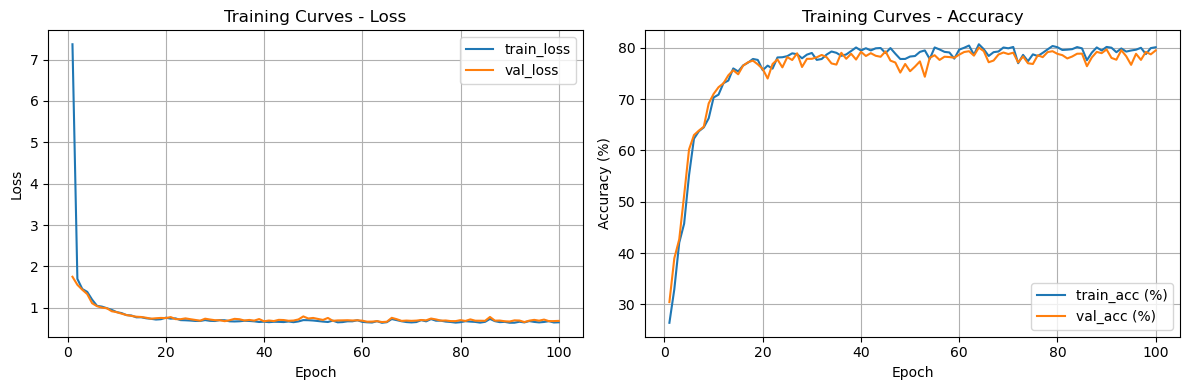

In [42]:
uf.plot_history(HISTORY)